In [1]:
import requests
import apimoex # pip install apimoex

import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import talib #pip install TA_Lib-0.4.24-cp310-cp310-win_amd64.whl
from mpl_finance import candlestick2_ohlc, volume_overlay2, plot_day_summary_oclh #pip install mpl_finance

%matplotlib inline

c:\Users\Никита Широкопетлев\AppData\Local\Programs\Python\Python310\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


Сравнение объёмов по дням недели

In [2]:
def to_date(string):
    yyyy = int(string[0:4])
    mm = int(string[5:7])
    dd = int(string[8:10])
    return datetime.date(yyyy, mm, dd)

In [3]:
class viewer():
    def __init__(self) -> None:
        self.moment = datetime.datetime.now()
        self.instrument = 'SBER'
        self.timeframes = {
            1: 'minutes',
            10: 'ten minutes',
            60: 'hours'}
        self.candles = {
            'minutes': [],
            'ten minutes': [],
            'hours': []
        }

    def get_timeframes(self, steps=5000):        
        for timeframe in self.timeframes.keys():
            self.start_date = self.moment - datetime.timedelta(minutes=steps*timeframe)
            self.candles[self.timeframes[timeframe]] = apimoex.get_market_candles(
                requests.Session(), self.instrument, timeframe, start=str(self.start_date), end=str(self.moment))

    def reorganize_candles(self):
        self.sep_candles = {}
        for tf_key, tf_value in self.candles.items():
            self.sep_candles[tf_key] = {
                'begin': [],
                'open': [],
                'close': [],
                'high': [],
                'low': [],
                'value': []}
            for candle in tf_value:
                for key, value in candle.items():
                    self.sep_candles[tf_key][key].append(value)


In [4]:
view = viewer()
view.get_timeframes()
view.reorganize_candles()

In [5]:
print(view.candles['minutes'][0])
print(len(view.sep_candles['minutes']['open']))

{'begin': '2023-01-24 09:59:00', 'open': 153.95, 'close': 153.95, 'high': 153.95, 'low': 153.95, 'value': 11099795}
2876


In [6]:
lim = 120
view.sep_candles['minutes']['close'] = np.asarray(view.sep_candles['minutes']['close'])
macd, macdsignal, macdhist = talib.MACD(view.sep_candles['minutes']['close'], fastperiod=12, slowperiod=26, signalperiod=9)

low = 0
up = low + lim

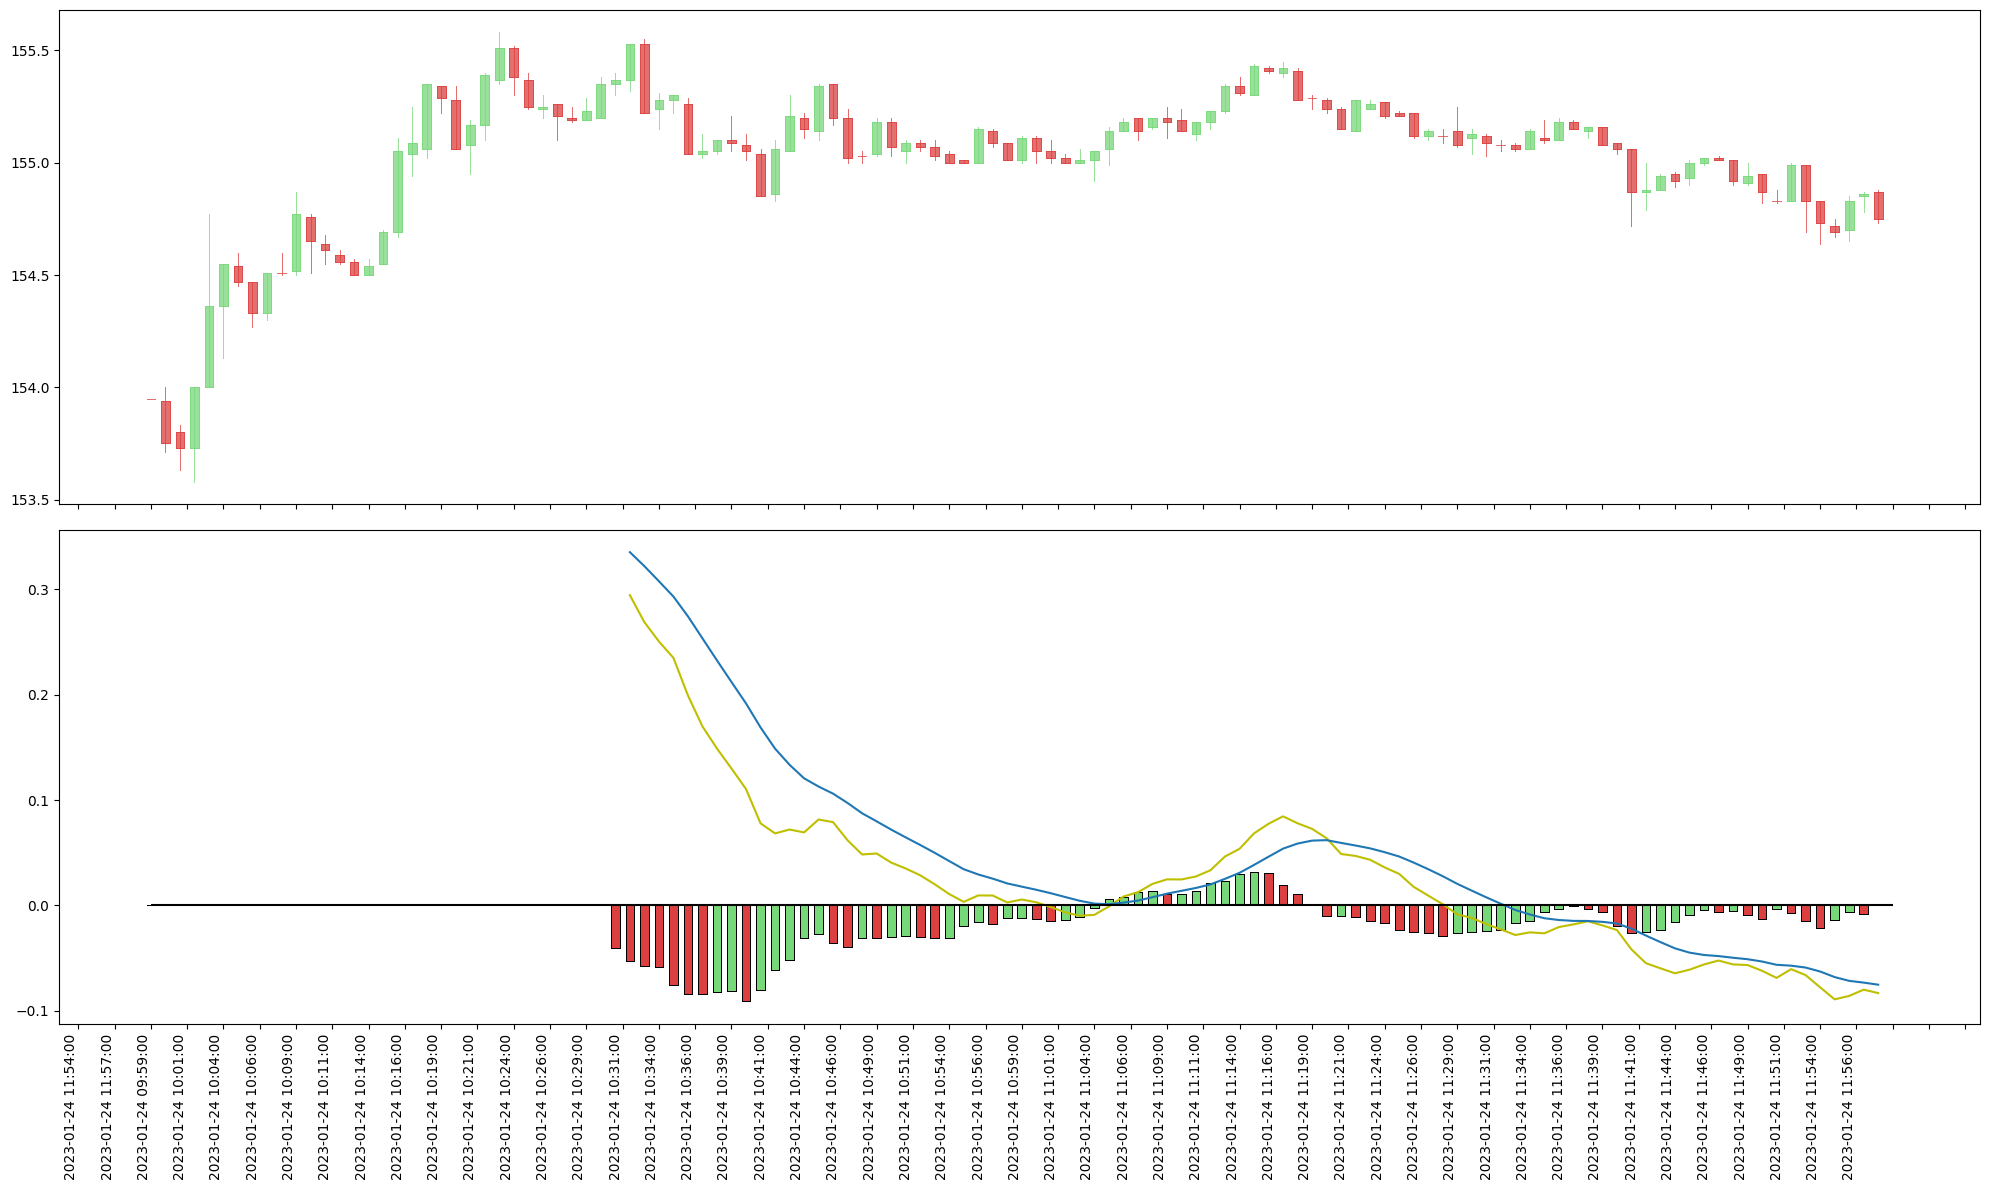

In [7]:
# оформить в функцию

fig, ax = plt.subplots(2, sharex=True, figsize=(20, 12))

ax[0].xaxis.set_major_locator(ticker.MaxNLocator(60))
ax[0].yaxis.set_major_locator(ticker.MaxNLocator(5))
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(5))
candlestick2_ohlc(ax[0], view.sep_candles['minutes']['open'][low:up],
    view.sep_candles['minutes']['high'][low:up], view.sep_candles['minutes']['low'][low:up],
    view.sep_candles['minutes']['close'][low:up], width=0.6, colorup='#77d879', colordown='#db3f3f')

xdate = view.sep_candles['minutes']['begin'][low:up]
def chart_date(x,pos):
    try:
        return xdate[int(x)]
    except IndexError:
        return ''

ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(chart_date))

fig.autofmt_xdate(rotation=90)
fig.tight_layout()

ax[1].plot(macd[low:up], color="y")
ax[1].plot(macdsignal[low:up])
ax[1].hlines(0, 0, lim, color = 'black')

idx = np.argwhere(np.diff(np.sign(macd[low:up] - macdsignal[low:up])) != 0).reshape(-1) + 0
inters_g ,inters_r = [], []

flag = not True
for offset, elem in enumerate(macd[low:up]):
    if offset in idx and flag:
        inters_g.append(np.nan)
        inters_r.append(elem)
        flag = False
    elif offset in idx and not flag:
        inters_g.append(elem)
        inters_r.append(np.nan)
        flag = True
    else:
        inters_g.append(np.nan)
        inters_r.append(np.nan)
#ax[1].plot(inters_g, 'g^')
#ax[1].plot(inters_r, 'rv')

hist_data = []
bascet = 0
for offset, elem in enumerate(macdhist[low:up]):   
    hist_data.append((macd[low:up][offset] - macdsignal[low:up][offset]))
#volume_overlay(ax[2],quotes['open'],quotes['close'],quotes['volume'], colorup='g', colordown='r', width=1)
volume_overlay2(ax[1],macd[low:up] - macdsignal[low:up],hist_data, colorup='#77d879', colordown='#db3f3f', width=0.6)
plt.show()